In [1]:
%load_ext autoreload
%autoreload 2

import rasterio
import pandas as pd 

from SARLens.utils.io import plot_with_cdf, plot2_with_cdf, read_tif, dump, load, plot_histogram
from SARLens.utils.printsummary import summarize_2d_array
from SARLens.autofocus.metrics import ssim, psnr

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Zarr packet not installed. Zarr functionalities will not work.


# First Matching SAR - SLC

In [ ]:
RAW_PATH = '/Users/robertodelprete/Desktop/AutoFocusNet/Data/DECODED/s1a-s3-raw-s-hh-20240524t213606-20240524t213631-054018-069139/focused-s1a-s3-raw-s-hh-20240524t213606-20240524t213631-054018-069139.pkl'
SLC_PATH = '/Users/robertodelprete/Desktop/AutoFocusNet/Data/SLC-SRC/S1A_S3_SLC__1SDH_20240524T213606_20240524T213631_054018_069139_A9AD.SAFE/measurement/s1a-s3-slc-hh-20240524t213606-20240524t213631-054018-069139-001.tiff'

SLC = read_tif(SLC_PATH)
RAW = pd.read_pickle(RAW_PATH)

In [ ]:
# Print the number of columns in RAW and SLC
print("Number of columns in RAW:", RAW.shape[1])
print("Number of columns in SLC:", SLC.shape[1])

# Calculate and print the difference
cdifference = RAW.shape[1] - SLC.shape[1]
print("Difference in the number of columns:", cdifference)

# Print the number of rows in RAW and SLC
print("Number of rows in RAW:", RAW.shape[0])
print("Number of rows in SLC:", SLC.shape[0])

# Calculate and print the difference
rdifference = RAW.shape[0] - SLC.shape[0]
print("Difference in the number of rows:", rdifference)
print("This is huge because we are not taking into account the other burst (9).")

In [ ]:
cstart_idx = int(abs(cdifference/2))

# Total packets is:
# BurstID   rows        %  
# 8         19250       39.333074518297536
# 9         28875       58.99961177744631

rstart_idx = int(abs((SLC.shape[0] - (19250+28875))/2))

In [ ]:
#                 !* Match the size of the Burst 8
SLC_view = SLC[0:RAW.shape[0], :7500]
RAW_view = RAW[0:, cstart_idx:cstart_idx+7500]

plot_with_cdf(SLC_view)
plot_with_cdf(RAW_view)

In [ ]:
dump(obj=SLC_view, filename='./dump/SLC.pkl')
dump(obj=RAW_view, filename='./dump/RAW.pkl')

# Second Matching RAW - SLC

In [2]:
RAW, SLC = load('./dump/RAW.pkl'), load('./dump/SLC.pkl') 

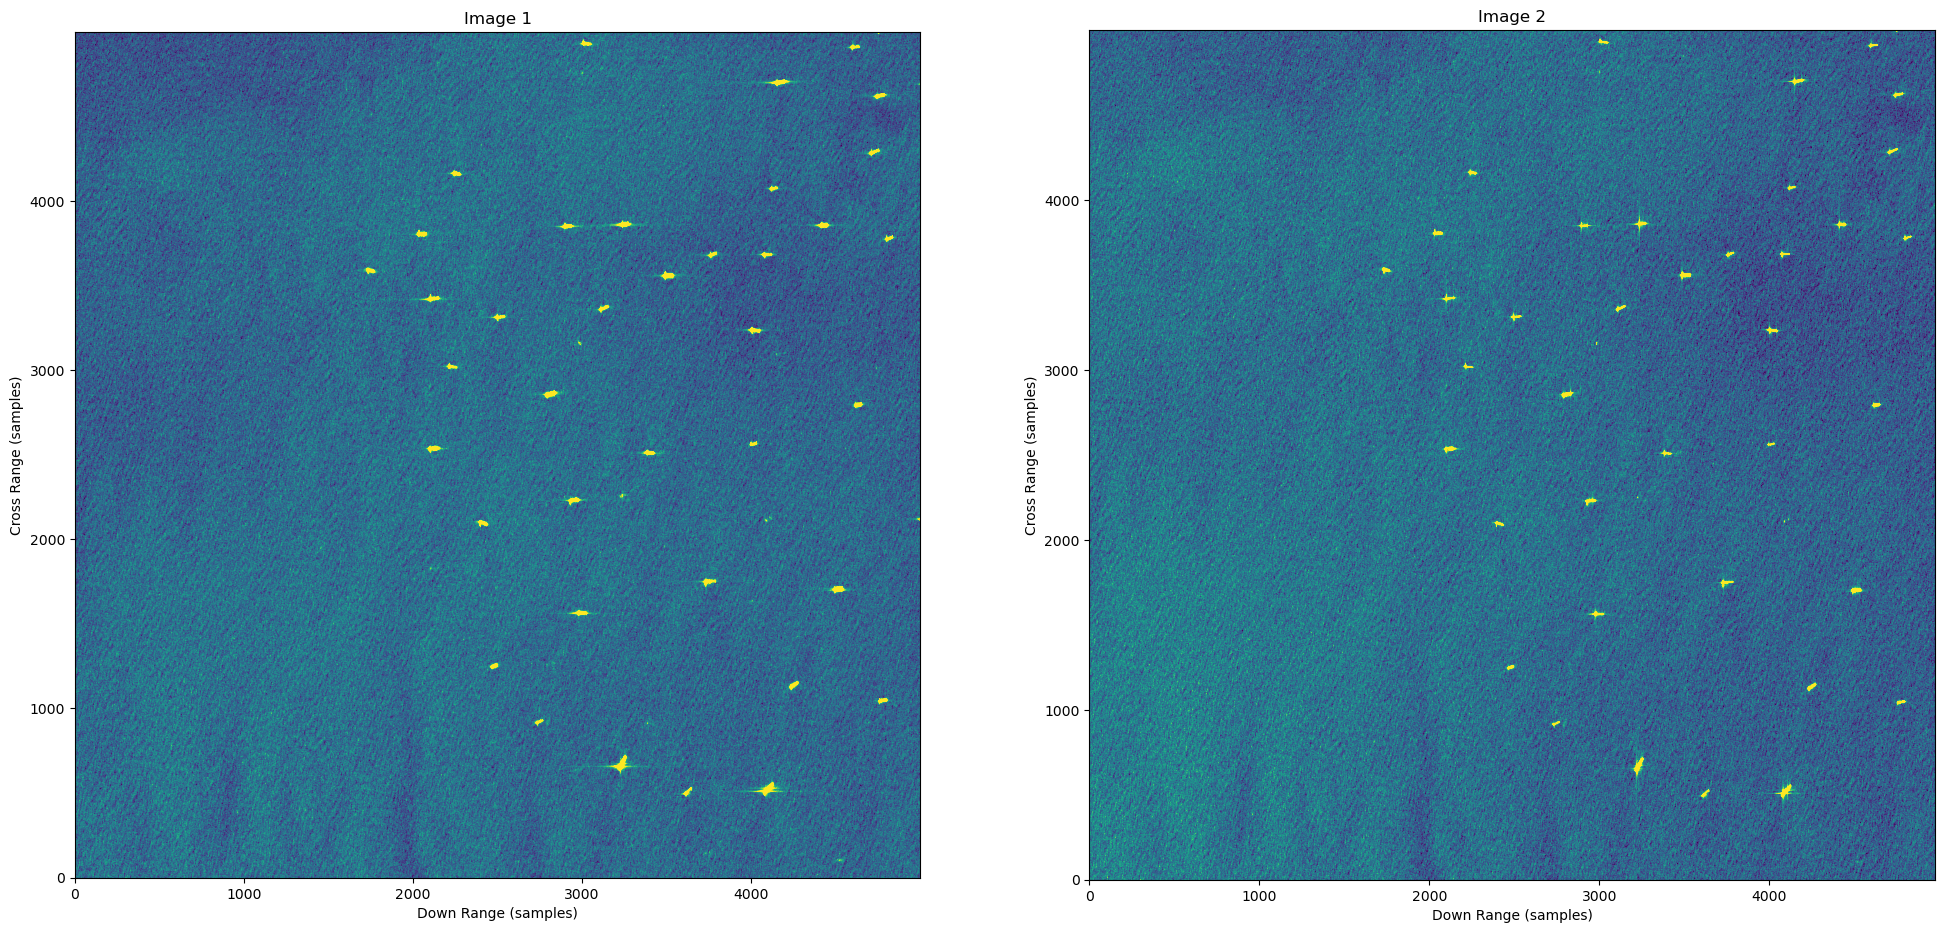

ValueError: operands could not be broadcast together with shapes (5000,4975) (5000,5000) 

In [20]:
A=2000
B=2500
hsize = 5000
vsize = 5000

rstart_idx = 1301//2 + 18
cstart_idx = 0

cstart_idx2 = 25


view_raw, view_slc = RAW[A+rstart_idx:A+rstart_idx+hsize, cstart_idx+B:cstart_idx+B+vsize], SLC[A:A+hsize, cstart_idx2+B:cstart_idx2+B+vsize]

# Set values where view_slc is zero to a very small number to avoid division by zero
import numpy as np

def safe_convert(img):
    img = np.where(img == 0, 1e-10, img)
    return img



view_raw, view_slc = safe_convert(view_raw), safe_convert(view_slc)

# print('RAW')
# summarize_2d_array(abs(view_raw))
# print('\nSLC')
# summarize_2d_array(abs(view_slc))

fig = plot2_with_cdf(view_raw, view_slc)
fig.savefig('../figures/coarseRDA_vs_trueRDA.png')

ratio = abs(view_slc)/abs(view_raw)
diff = abs(view_raw)-abs(view_slc)

print('Average ratio:', ratio.mean())

# plot_with_cdf(ratio, savepath='../figures/ratio_coarseRDA_vs_trueRDA.png')
# plot_with_cdf(diff, savepath='../figures/ratio_coarseRDA_vs_trueRDA.png')
# print('PSNR:')
# print(psnr(abs(view_raw), abs(view_slc)))
# ssim(abs(view_raw), abs(view_slc))

In [19]:
from SARLens.autofocus.metrics import structure, luminance, contrast

print('structure: ',structure(abs(view_slc),abs(view_raw)))
print('luminance:', luminance(abs(view_slc),abs(view_raw)))
print('contrast', contrast(abs(view_slc),abs(view_raw)))



structure:  0.9017976560742305
luminance: 0.22055779058643973
contrast 0.6574110708823935


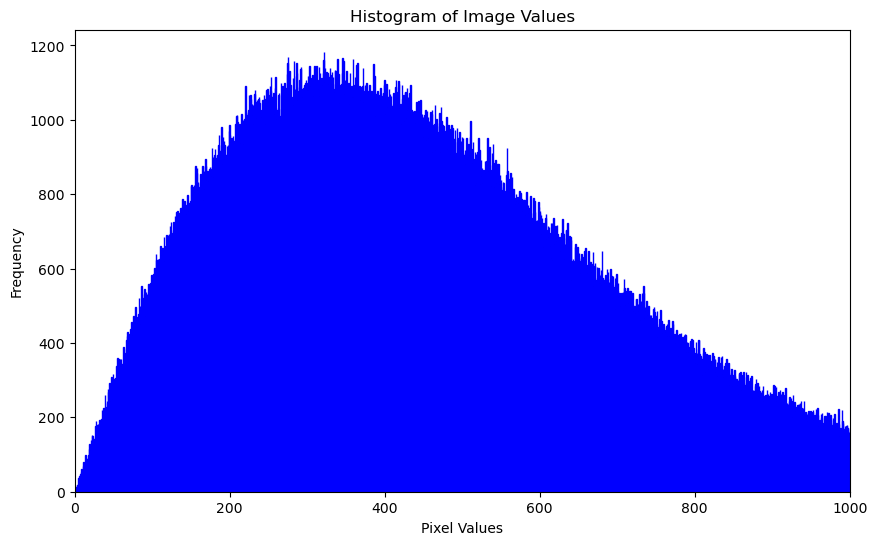

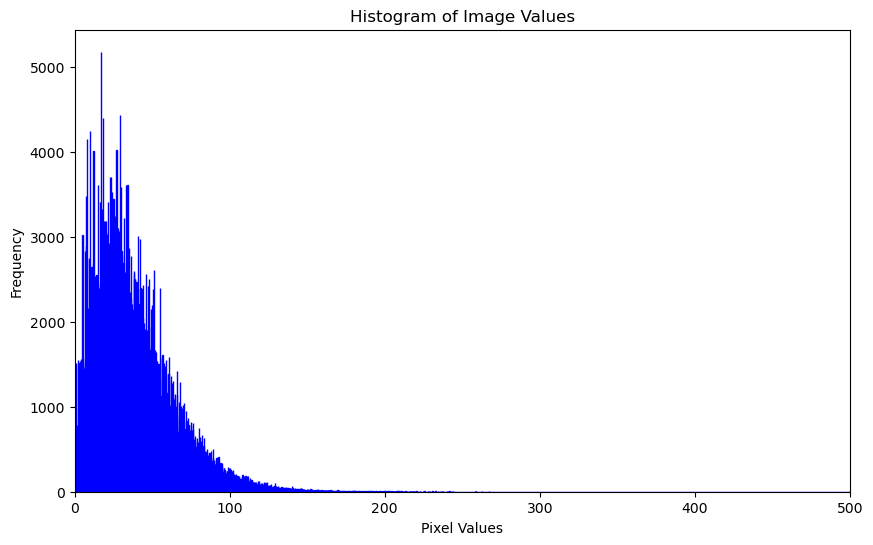

In [16]:
plot_histogram(abs(view_raw), xlim=[0,1000])
plot_histogram(abs(view_slc))

In [ ]:
plot_histogram(diff, savepath='../figures/coarseRDA_vs_trueRDA_histogram_diff.png')
plot_histogram(ratio, xlim=[0,100],savepath='../figures/coarseRDA_vs_trueRDA_histogram_ratio.png')